In [41]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import main

In [42]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, new_dataset.num_points) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [43]:
model = torch.load('model.pth', weights_only=False)

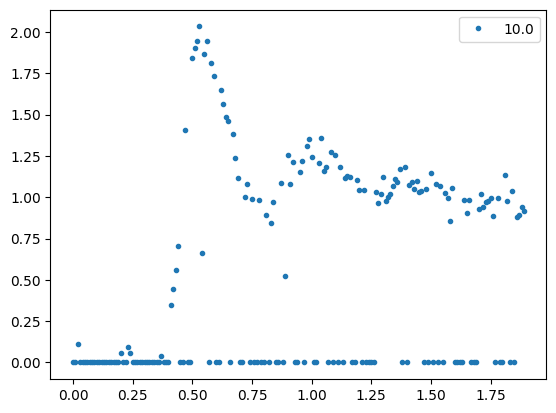

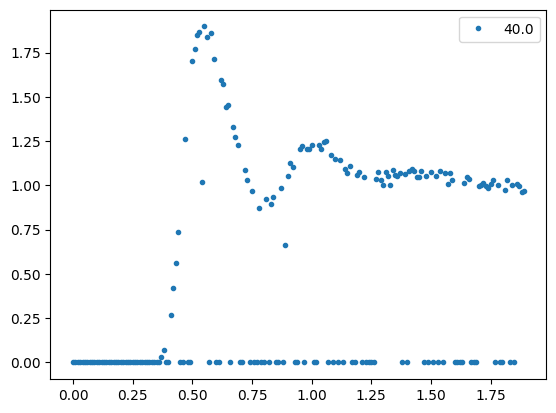

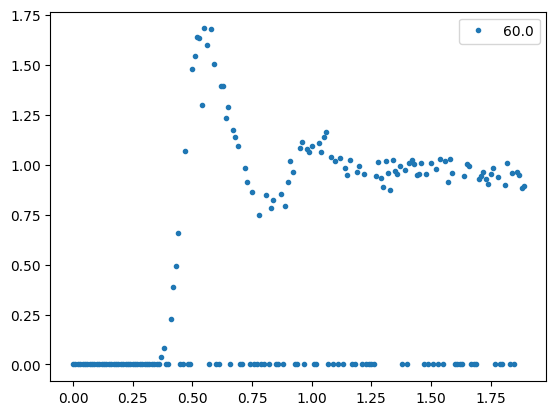

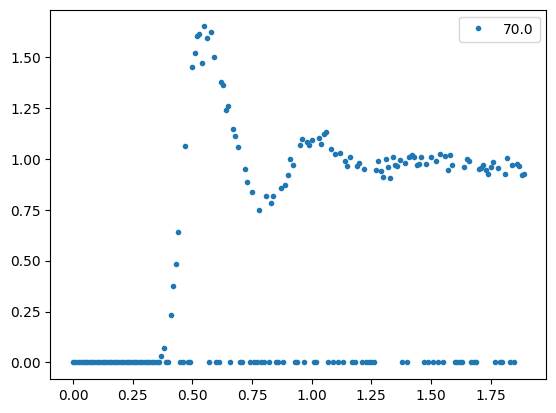

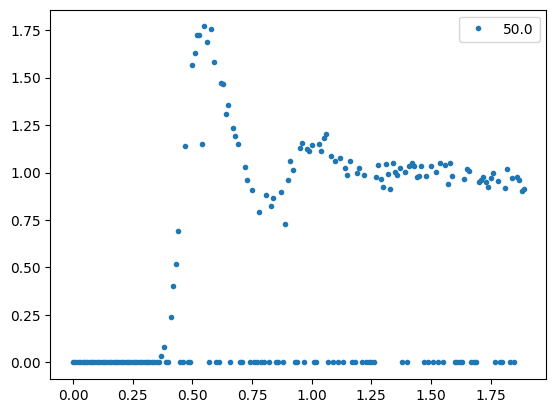

In [44]:
model.eval()
#fig, axes = plt.subplots(5)

with torch.no_grad():
    count = 0
    for i in main.for_test:
        X = main.new_dataset.x_data[i].to(main.device)
        pred = model(X).cpu()
        plt.plot(main.new_dataset.r_values, pred, "o", ms = 3, label = f"{X.item()}")
        count += 1
        plt.legend()
        plt.show()